In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import copy
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import os
from scipy.stats import norm, skew
print(os.listdir("../input"))

import seaborn as sns
color = sns.color_palette()

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


**Import data**

In [2]:
data = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sub_df = pd.read_csv('../input/sample_submission.csv')

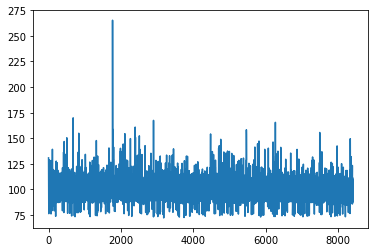

In [3]:
plt.plot(data['ID'],data['y'])

**Remove outliers**

In [4]:
data = data[data.y < 250]

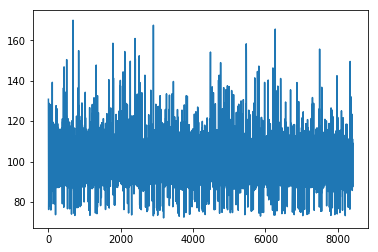

In [5]:
plt.plot(data['ID'],data['y'])

**Target Transformation**


 mu = 100.63 and sigma = 12.42



/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'target distribution')

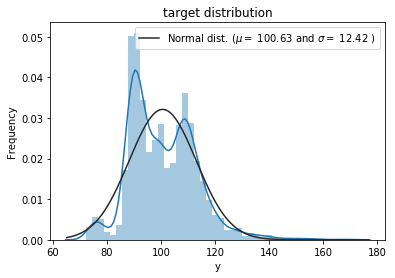

In [6]:
sns.distplot(data['y'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['y'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('target distribution')

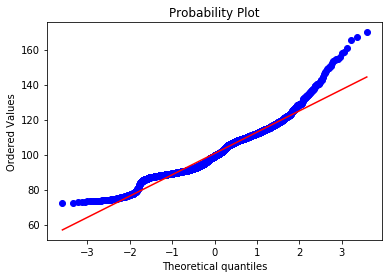

In [7]:
from scipy import stats

fig = plt.figure()
res = stats.probplot(data['y'], plot=plt)
plt.show()


 mu = 4.61 and sigma = 0.12



/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'target distribution')

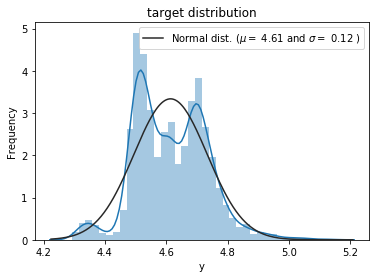

In [8]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data["y"] = np.log1p(data["y"])

#Check the new distribution 
sns.distplot(data['y'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['y'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('target distribution')

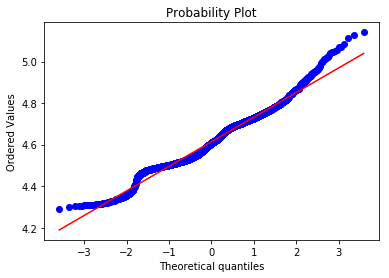

In [9]:
from scipy import stats

fig = plt.figure()
res = stats.probplot(data['y'], plot=plt)
plt.show()

**Categorical variables One-Hot Encoding **

In [10]:
train_objs_num = len(data)
dataset = pd.concat(objs=[data, test], axis=0)
dataset = pd.get_dummies(dataset)
data = copy.copy(dataset[:train_objs_num])
test = copy.copy(dataset[train_objs_num:])

In [11]:
useless_var = data.mean()[data.mean() == 0].index
y_train = data.y
data.drop('y', axis = 1, inplace=True)
data.drop('ID', axis = 1, inplace= True)
data.drop(useless_var.values, axis = 1, inplace=True)

test.drop('y', axis = 1, inplace=True)
test.drop('ID', axis = 1, inplace= True)
test.drop(useless_var.values, axis = 1, inplace=True)

**Features engineering**

In [12]:
depth1= ['X314', 'X315', 'X118', 'X232', 'X136', 'X127', 'X189', 'X261', 'X47', 'X236', 'X5_n', 'X5_w', 'X383', 'X204', 'X339', 'X275', 'X152', 'X50', 'X1_f', 'X6_e', 'X5_r', 'X104', 'X5_aa', 'X240', 'X206', 'X241', 'X95', 'X1_l', 'X113', 'X5_ag', 'X8_s', 'X5_v', 'X100', 'X13', 'X8_k', 'X6_c', 'X223', 'X114', 'X19', 'X115', 'X1_u', 'X80', 'X4_c', 'X68', 'X168', 'X306', 'X61', 'X350', 'X300', 'X132', 'X342', 'X1_c', 'X6_l', 'X267', 'X379', 'X23', 'X316', 'X8_j', 'X6_g', 'X5_m', 'X12', 'X0_z', 'X0_x', 'X77', 'X354', 'X196', 'X8_a', 'X283', 'X51', 'X8_g', 'X225', 'X292', 'X2_r', 'X148', 'X8_d', 'X8_x', 'X203', 'X5_k', 'X8_o', 'X101', 'X220', 'X191', 'X5_ab', 'X8_i', 'X8_w', 'X56', 'X65', 'X0_ab', 'X131', 'X224', 'X155', 'X181', 'X351', 'X0_au', 'X64', 'X75', 'X5_af', 'X105', 'X6_j', 'X117', 'X151', 'X177', 'X0_l', 'X362', 'X3_g', 'X5_l', 'X8_v', 'X285', 'X378', 'X244', 'X343', 'X228', 'X5_ae', 'X5_p', 'X273', 'X380', 'X5_ah', 'X27', 'X1_t', 'X6_h', 'X345', 'X1_h', 'X176', 'X116', 'X171', 'X1_aa', 'X6_d', 'X201', 'X122', 'X3_a', 'X5_ad', 'X178', 'X143', 'X38', 'X142', 'X14', 'X361', 'X1_q']
depth2= [('X118', 'X314'), ('X314', 'X315'), ('X232', 'X314'), ('X136', 'X315'), ('X127', 'X232'), ('X189', 'X315'), ('X232', 'X315'), ('X314', 'X47'), ('X261', 'X47'), ('X315', 'X47'), ('X232', 'X261'), ('X113', 'X118'), ('X118', 'X261'), ('X261', 'X5_r'), ('X236', 'X47'), ('X314', 'X61'), ('X232', 'X5_k'), ('X115', 'X261'), ('X206', 'X50'), ('X236', 'X261'), ('X5_w', 'X8_k'), ('X383', 'X50'), ('X315', 'X6_c'), ('X232', 'X47'), ('X241', 'X5_n'), ('X47', 'X5_w'), ('X236', 'X275'), ('X1_l', 'X5_aa'), ('X127', 'X136'), ('X261', 'X61'), ('X152', 'X5_n'), ('X143', 'X315'), ('X118', 'X5_w'), ('X118', 'X5_r'), ('X5_aa', 'X5_w'), ('X104', 'X118'), ('X152', 'X383'), ('X275', 'X5_n'), ('X118', 'X236'), ('X383', 'X5_n'), ('X351', 'X47'), ('X5_aa', 'X80'), ('X113', 'X261'), ('X240', 'X6_l'), ('X236', 'X314'), ('X13', 'X1_l'), ('X316', 'X6_e'), ('X115', 'X1_f'), ('X275', 'X339'), ('X114', 'X1_c'), ('X136', 'X232'), ('X127', 'X6_e'), ('X339', 'X47'), ('X47', 'X61'), ('X115', 'X314'), ('X168', 'X8_k'), ('X1_u', 'X47'), ('X151', 'X236'), ('X127', 'X47'), ('X152', 'X19'), ('X223', 'X6_g'), ('X118', 'X1_aa'), ('X104', 'X68'), ('X101', 'X152'), ('X306', 'X5_w'), ('X23', 'X8_k'), ('X113', 'X314'), ('X5_r', 'X5_w'), ('X47', 'X5_n'), ('X383', 'X6_l'), ('X127', 'X5_n'), ('X204', 'X5_n'), ('X6_l', 'X8_j'), ('X0_x', 'X47'), ('X300', 'X383'), ('X240', 'X8_s'), ('X5_n', 'X5_w'), ('X1_c', 'X5_r'), ('X100', 'X342'), ('X196', 'X5_n'), ('X47', 'X5_aa'), ('X0_z', 'X152'), ('X47', 'X5_ad'), ('X204', 'X383'), ('X379', 'X5_m'), ('X105', 'X232'), ('X19', 'X5_n'), ('X118', 'X1_q'), ('X261', 'X339'), ('X191', 'X339'), ('X350', 'X47'), ('X236', 'X240'), ('X5_r', 'X8_v'), ('X148', 'X95'), ('X127', 'X339'), ('X350', 'X5_n'), ('X132', 'X283'), ('X77', 'X8_j'), ('X1_l', 'X56'), ('X0_x', 'X1_u'), ('X12', 'X5_ag'), ('X1_f', 'X8_d'), ('X204', 'X236'), ('X204', 'X316'), ('X116', 'X47'), ('X113', 'X8_a'), ('X6_l', 'X77'), ('X204', 'X95'), ('X225', 'X383'), ('X100', 'X5_ab'), ('X100', 'X1_f'), ('X5_m', 'X8_s'), ('X19', 'X6_g'), ('X115', 'X8_s'), ('X339', 'X383'), ('X127', 'X1_f'), ('X118', 'X316'), ('X204', 'X5_aa'), ('X118', 'X8_a'), ('X115', 'X155'), ('X1_f', 'X5_v'), ('X104', 'X275'), ('X132', 'X1_l'), ('X1_f', 'X3_g'), ('X1_c', 'X315'), ('X23', 'X5_w'), ('X132', 'X339'), ('X116', 'X77'), ('X12', 'X383'), ('X2_r', 'X8_a'), ('X131', 'X5_aa'), ('X51', 'X5_k'), ('X5_ah', 'X8_g'), ('X204', 'X4_c'), ('X383', 'X5_v'), ('X362', 'X5_n'), ('X220', 'X342'), ('X204', 'X339'), ('X132', 'X354'), ('X132', 'X203'), ('X204', 'X240'), ('X383', 'X5_l'), ('X236', 'X292'), ('X1_c', 'X343'), ('X267', 'X95'), ('X292', 'X378'), ('X350', 'X5_l'), ('X345', 'X61'), ('X240', 'X8_o'), ('X117', 'X275'), ('X306', 'X5_n'), ('X100', 'X8_o'), ('X0_x', 'X224'), ('X5_n', 'X6_j'), ('X178', 'X61'), ('X236', 'X383'), ('X19', 'X5_m'), ('X236', 'X95'), ('X132', 'X5_v'), ('X132', 'X6_g'), ('X132', 'X236'), ('X19', 'X204'), ('X5_ag', 'X5_k'), ('X315', 'X6_g'), ('X240', 'X8_x'), ('X267', 'X316'), ('X383', 'X75'), ('X261', 'X383'), ('X105', 'X5_ag'), ('X267', 'X383'), ('X5_v', 'X5_w'), ('X65', 'X6_j'), ('X177', 'X267'), ('X342', 'X95'), ('X354', 'X6_j'), ('X306', 'X75'), ('X12', 'X95'), ('X115', 'X64'), ('X105', 'X114'), ('X181', 'X316'), ('X350', 'X380'), ('X383', 'X5_r'), ('X383', 'X8_x'), ('X292', 'X5_n'), ('X113', 'X3_a'), ('X142', 'X68'), ('X0_x', 'X351'), ('X292', 'X339'), ('X342', 'X5_m'), ('X1_l', 'X8_w'), ('X204', 'X47'), ('X151', 'X6_g'), ('X6_h', 'X75'), ('X240', 'X342'), ('X1_h', 'X64'), ('X12', 'X5_v'), ('X267', 'X51'), ('X342', 'X5_ag'), ('X176', 'X8_s'), ('X339', 'X4_c'), ('X171', 'X64'), ('X339', 'X8_d'), ('X206', 'X383'), ('X285', 'X350'), ('X342', 'X5_v'), ('X14', 'X68'), ('X1_u', 'X203'), ('X148', 'X244'), ('X203', 'X4_c'), ('X228', 'X8_w'), ('X342', 'X5_aa'), ('X12', 'X5_r'), ('X0_au', 'X339'), ('X132', 'X8_i'), ('X203', 'X267'), ('X0_au', 'X0_z'), ('X100', 'X23'), ('X350', 'X8_v'), ('X292', 'X8_d'), ('X177', 'X1_u'), ('X4_c', 'X5_w'), ('X148', 'X267'), ('X104', 'X95'), ('X339', 'X95'), ('X1_t', 'X5_ae'), ('X206', 'X8_i'), ('X228', 'X5_aa'), ('X315', 'X351'), ('X104', 'X342'), ('X5_p', 'X8_a'), ('X0_l', 'X4_c'), ('X104', 'X206'), ('X5_v', 'X8_d'), ('X5_m', 'X95'), ('X316', 'X5_ah'), ('X104', 'X5_w'), ('X1_t', 'X8_a'), ('X292', 'X5_ag'), ('X292', 'X5_af'), ('X1_u', 'X6_d'), ('X306', 'X4_c'), ('X0_ab', 'X4_c'), ('X5_aa', 'X5_ah'), ('X240', 'X275'), ('X240', 'X95'), ('X342', 'X5_af'), ('X273', 'X5_ae'), ('X0_au', 'X5_r'), ('X115', 'X177'), ('X0_ab', 'X204')]
depth3=[('X136', 'X314', 'X315'), ('X127', 'X232', 'X314'), ('X189', 'X314', 'X315'), ('X232', 'X314', 'X315'), ('X113', 'X118', 'X314'), ('X314', 'X315', 'X47'), ('X143', 'X314', 'X315'), ('X232', 'X314', 'X47'), ('X314', 'X315', 'X6_c'), ('X118', 'X1_q', 'X314'), ('X118', 'X261', 'X5_r'), ('X236', 'X314', 'X47'), ('X118', 'X1_aa', 'X314'), ('X261', 'X315', 'X47'), ('X232', 'X261', 'X5_k'), ('X118', 'X314', 'X5_r'), ('X118', 'X314', 'X8_a'), ('X118', 'X1_aa', 'X261'), ('X261', 'X5_r', 'X8_v'), ('X127', 'X232', 'X261'), ('X314', 'X47', 'X61'), ('X236', 'X261', 'X275'), ('X206', 'X383', 'X50'), ('X178', 'X314', 'X61'), ('X127', 'X136', 'X232'), ('X115', 'X1_f', 'X261'), ('X236', 'X261', 'X47'), ('X115', 'X261', 'X8_s'), ('X104', 'X118', 'X5_w'), ('X136', 'X232', 'X261'), ('X118', 'X236', 'X5_w'), ('X168', 'X5_w', 'X8_k'), ('X261', 'X47', 'X5_ad'), ('X23', 'X5_w', 'X8_k'), ('X275', 'X383', 'X5_n'), ('X261', 'X47', 'X5_w'), ('X261', 'X47', 'X61'), ('X152', 'X19', 'X5_n'), ('X261', 'X345', 'X61'), ('X261', 'X5_r', 'X5_w'), ('X127', 'X232', 'X47'), ('X261', 'X350', 'X47'), ('X113', 'X314', 'X47'), ('X13', 'X1_l', 'X5_aa'), ('X127', 'X232', 'X6_e'), ('X0_x', 'X1_u', 'X47'), ('X113', 'X261', 'X8_a'), ('X0_x', 'X351', 'X47'), ('X232', 'X51', 'X5_k'), ('X306', 'X47', 'X5_w'), ('X315', 'X351', 'X47'), ('X241', 'X47', 'X5_n'), ('X204', 'X316', 'X6_e'), ('X115', 'X1_f', 'X314'), ('X232', 'X5_ag', 'X5_k'), ('X240', 'X383', 'X6_l'), ('X114', 'X1_c', 'X5_r'), ('X127', 'X232', 'X5_n'), ('X113', 'X261', 'X3_a'), ('X115', 'X155', 'X314'), ('X241', 'X275', 'X5_n'), ('X383', 'X6_l', 'X8_j'), ('X101', 'X152', 'X383'), ('X47', 'X5_n', 'X5_w'), ('X19', 'X223', 'X6_g'), ('X47', 'X5_w', 'X8_k'), ('X196', 'X275', 'X5_n'), ('X47', 'X5_aa', 'X80'), ('X191', 'X275', 'X339'), ('X0_x', 'X224', 'X47'), ('X1_l', 'X47', 'X5_aa'), ('X261', 'X339', 'X47'), ('X236', 'X240', 'X275'), ('X5_aa', 'X5_w', 'X80'), ('X300', 'X383', 'X5_l'), ('X0_z', 'X152', 'X19'), ('X127', 'X232', 'X339'), ('X148', 'X267', 'X95'), ('X1_l', 'X5_aa', 'X5_w'), ('X152', 'X204', 'X383'), ('X204', 'X350', 'X5_n'), ('X1_l', 'X56', 'X5_aa'), ('X105', 'X232', 'X5_ag'), ('X204', 'X236', 'X47'), ('X105', 'X114', 'X232'), ('X132', 'X283', 'X339'), ('X19', 'X204', 'X5_n'), ('X151', 'X236', 'X275'), ('X339', 'X383', 'X47'), ('X127', 'X1_f', 'X232'), ('X204', 'X5_aa', 'X5_w'), ('X100', 'X342', 'X5_ab'), ('X100', 'X1_f', 'X5_v'), ('X6_l', 'X77', 'X8_j'), ('X131', 'X204', 'X5_aa'), ('X12', 'X5_ag', 'X5_r'), ('X225', 'X383', 'X5_r'), ('X118', 'X204', 'X316'), ('X204', 'X383', 'X5_v'), ('X104', 'X275', 'X339'), ('X116', 'X351', 'X47'), ('X1_f', 'X236', 'X8_d'), ('X132', 'X1_l', 'X5_v'), ('X1_f', 'X3_g', 'X5_v'), ('X132', 'X339', 'X354'), ('X152', 'X19', 'X204'), ('X204', 'X383', 'X50'), ('X12', 'X383', 'X5_l'), ('X204', 'X339', 'X5_n'), ('X1_c', 'X315', 'X5_r'), ('X5_aa', 'X5_r', 'X5_w'), ('X151', 'X236', 'X47'), ('X116', 'X13', 'X47'), ('X117', 'X275', 'X339'), ('X116', 'X6_l', 'X77'), ('X306', 'X362', 'X5_n'), ('X1_t', 'X2_r', 'X8_a'), ('X236', 'X383', 'X95'), ('X100', 'X342', 'X8_o'), ('X220', 'X342', 'X5_aa'), ('X19', 'X204', 'X5_m'), ('X5_aa', 'X5_ah', 'X8_g'), ('X132', 'X236', 'X5_v'), ('X1_u', 'X47', 'X95'), ('X100', 'X240', 'X342'), ('X1_c', 'X343', 'X5_r'), ('X5_aa', 'X5_w', 'X8_k'), ('X379', 'X5_m', 'X95'), ('X267', 'X316', 'X383'), ('X240', 'X6_l', 'X8_o'), ('X306', 'X5_n', 'X6_j'), ('X12', 'X342', 'X95'), ('X350', 'X380', 'X5_l'), ('X5_aa', 'X5_v', 'X5_w'), ('X261', 'X383', 'X5_r'), ('X204', 'X383', 'X8_x'), ('X19', 'X315', 'X6_g'), ('X306', 'X383', 'X75'), ('X292', 'X339', 'X5_n'), ('X240', 'X6_l', 'X8_x'), ('X1_l', 'X5_aa', 'X8_w'), ('X267', 'X383', 'X51'), ('X240', 'X342', 'X5_m'), ('X1_h', 'X241', 'X5_n'), ('X0_l', 'X379', 'X5_m'), ('X204', 'X47', 'X95'), ('X177', 'X1_u', 'X267'), ('X132', 'X203', 'X6_g'), ('X23', 'X5_aa', 'X5_w'), ('X181', 'X204', 'X316'), ('X176', 'X240', 'X8_s'), ('X104', 'X142', 'X68'), ('X306', 'X6_h', 'X75'), ('X339', 'X4_c', 'X8_d'), ('X0_ab', 'X65', 'X6_j'), ('X0_ab', 'X354', 'X6_j'), ('X115', 'X1_h', 'X64'), ('X204', 'X240', 'X95'), ('X5_m', 'X8_s', 'X95'), ('X12', 'X5_r', 'X5_v'), ('X104', 'X5_w', 'X68'), ('X132', 'X203', 'X4_c'), ('X151', 'X19', 'X6_g'), ('X292', 'X339', 'X378'), ('X342', 'X5_aa', 'X5_v'), ('X148', 'X244', 'X95'), ('X115', 'X177', 'X267'), ('X203', 'X267', 'X4_c'), ('X151', 'X236', 'X383'), ('X0_au', 'X0_z', 'X339'), ('X104', 'X206', 'X383'), ('X240', 'X8_s', 'X95'), ('X285', 'X350', 'X5_l'), ('X1_u', 'X203', 'X47'), ('X104', 'X14', 'X68'), ('X342', 'X4_c', 'X5_ag'), ('X171', 'X1_h', 'X64'), ('X204', 'X4_c', 'X5_w'), ('X228', 'X5_aa', 'X8_w'), ('X100', 'X23', 'X5_w'), ('X236', 'X292', 'X8_d'), ('X104', 'X339', 'X95'), ('X204', 'X240', 'X8_s'), ('X132', 'X203', 'X8_i'), ('X0_l', 'X5_m', 'X8_s'), ('X0_l', 'X204', 'X4_c'), ('X350', 'X5_l', 'X8_v'), ('X104', 'X206', 'X8_i'), ('X104', 'X342', 'X5_w'), ('X1_t', 'X5_p', 'X8_a'), ('X0_au', 'X273', 'X339'), ('X236', 'X292', 'X5_ag'), ('X316', 'X5_aa', 'X5_ah'), ('X1_u', 'X47', 'X6_d'), ('X0_ab', 'X306', 'X4_c'), ('X236', 'X5_v', 'X8_d'), ('X236', 'X292', 'X5_af'), ('X240', 'X275', 'X95'), ('X1_t', 'X273', 'X5_ae'), ('X0_au', 'X4_c', 'X5_r'), ('X0_ab', 'X204', 'X5_ag'), ('X342', 'X4_c', 'X5_af'), ('X122', 'X1_t', 'X5_ae'), ('X19', 'X1_h', 'X5_n'), ('X236', 'X292', 'X378'), ('X204', 'X240', 'X261'), ('X114', 'X228', 'X5_aa'), ('X177', 'X203', 'X27'), ('X0_au', 'X201', 'X4_c'), ('X203', 'X27', 'X8_g'), ('X0_l', 'X131', 'X38'), ('X0_l', 'X131', 'X361')]

In [13]:
data = data[depth1]
test = test[depth1]
for (a,b) in depth2[0:17]:
    data.loc[:,a+'_+_'+b] = data[a].add(data[b])
    data.loc[:,a+'_*_'+b] = data[a].mul(data[b])
    #data.loc[:,a+'_-_'+b] = data[a].sub(data[b])
    data.loc[:,a+'_abs(-)_'+b] = np.abs(data[a].sub(data[b]))
    
    test.loc[:,a+'_+_'+b] = test[a].add(test[b])
    test.loc[:,a+'_*_'+b] = test[a].mul(test[b])
    #test.loc[:,a+'_-_'+b] = test[a].sub(test[b])
    test.loc[:,a+'_abs(-)_'+b] = np.abs(test[a].sub(test[b]))
    #data.loc[:,a+'_max_'+b] = np.maximum(data[a],data[b])
    #data.loc[:,a+'_min_'+b] = np.minimum(data[a],data[b])
    
for (a,b,c) in depth3[0:13]:
    data.loc[:,a+'_+_'+b+'_+_'+c] = data[a].add(data[b]).add(data[c])
    test.loc[:,a+'_+_'+b+'_+_'+c] = test[a].add(test[b]).add(test[c])
    data.loc[:,a+'_*_'+b+'_*_'+c] = data[a].mul(data[b]).mul(data[c])
    test.loc[:,a+'_*_'+b+'_*_'+c] = test[a].mul(test[b]).mul(test[c])
    data.loc[:,a+'_+_'+b+'_*_'+c] = data[a].add(data[b]).mul(data[c])
    test.loc[:,a+'_+_'+b+'_*_'+c] = test[a].add(test[b]).mul(test[c])
    data.loc[:,a+'_*_'+b+'_+_'+c] = data[a].mul(data[b]).add(data[c])
    test.loc[:,a+'_*_'+b+'_+_'+c] = test[a].mul(test[b]).add(test[c])
    
    test.loc[:,a+'_-_'+b+'_+_'+c] = np.abs(test[a].sub(test[b])).add(test[c])
    test.loc[:,a+'_-_'+b+'_*_'+c] = np.abs(test[a].sub(test[b])).mul(test[c])
    test.loc[:,a+'_*_'+b+'_-_'+c] = test[a].mul(np.abs((test[b]).sub(test[c])))
    test.loc[:,a+'_+_'+b+'_-_'+c] = test[a].add(np.abs((test[b]).sub(test[c])))
    test.loc[:,a+'_-_'+b+'_-_'+c] = np.abs(np.abs(test[a].sub(test[b])).sub(test[c]))
    
    data.loc[:,a+'_-_'+b+'_+_'+c] = np.abs(data[a].sub(data[b])).add(data[c])
    data.loc[:,a+'_-_'+b+'_*_'+c] = np.abs(data[a].sub(data[b])).mul(data[c])
    data.loc[:,a+'_*_'+b+'_-_'+c] = data[a].mul(np.abs((data[b]).sub(data[c])))
    data.loc[:,a+'_+_'+b+'_-_'+c] = data[a].add(np.abs((data[b]).sub(data[c])))
    data.loc[:,a+'_-_'+b+'_-_'+c] = np.abs(np.abs(data[a].sub(data[b])).sub(data[c]))

**Features selection**

In [14]:
from  itertools import combinations
from sklearn.metrics import matthews_corrcoef
cc = list(combinations(data.columns,2))
data_1 = [(c[0],c[1],abs(matthews_corrcoef(data[c[1]],data[c[0]]))) for c in cc]
#data_1.columns = data_1.columns.map('_*_'.join)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [15]:
to_drop = []
for (c1,c2,score) in data_1:
    if score >0.95:
        to_drop.append(c2)
print(to_drop)
data.drop(to_drop, axis=1, inplace = True)
test.drop(to_drop, axis=1, inplace = True)


['X261', 'X314_+_X47', 'X314_abs(-)_X47', 'X127_*_X232_+_X314', 'X113_*_X118_+_X314', 'X118_*_X1_q_+_X314', 'X236_+_X314_+_X47', 'X236_-_X314_+_X47', 'X236_+_X314_-_X47', 'X236_-_X314_-_X47', 'X136_*_X315', 'X189_*_X315', 'X136_+_X314_*_X315', 'X136_-_X314_*_X315', 'X127_+_X232_+_X314', 'X127_-_X232_+_X314', 'X127_+_X232_-_X314', 'X127_-_X232_-_X314', 'X189_+_X314_*_X315', 'X189_-_X314_*_X315', 'X232_*_X314_+_X315', 'X113_+_X118', 'X113_abs(-)_X118', 'X136', 'X136_-_X314_-_X315', 'X232_+_X314_+_X315', 'X232_-_X314_+_X315', 'X232_+_X314_-_X315', 'X232_-_X314_-_X315', 'X261_+_X47', 'X261_abs(-)_X47', 'X127_*_X232_+_X314', 'X118_*_X1_q_+_X314', 'X236_+_X47', 'X236_abs(-)_X47', 'X314_*_X315_+_X47', 'X232_*_X314_+_X47', 'X236_*_X314_+_X47', 'X113_*_X118', 'X113_*_X118_*_X314', 'X314_*_X315_+_X6_c', 'X118_+_X261', 'X113_+_X118_+_X314', 'X113_-_X118_+_X314', 'X118_+_X1_q_+_X314', 'X118_-_X1_q_+_X314', 'X118_+_X1_q_-_X314', 'X118_*_X261', 'X118_+_X1_q_*_X314', 'X118_-_X1_q_*_X314', 'X118_*_X1_

In [16]:
data.shape

(4208, 212)

In [17]:
from sklearn.model_selection import KFold, cross_val_score
n_folds = 5

def r2_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(data.values)
    r2= cross_val_score(model, data.values, y_train, scoring="r2", cv = kf)
    return(r2)


**XGBOOST**

In [18]:
model_xgb = xgb.XGBRegressor(alpha= 0, colsample_bytree= 1, eta= 0.005, reg_lambda= 0, max_depth= 4, min_child_weight= 0, n_estimators= 100)

In [19]:
#'alpha': 0, 'colsample_bytree': 1, 'eta': 0.005, 'lambda': 0, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 100
#XGB Parameter Tuning
gridParams = {
    'eta': [0.005],
    'max_depth': [3,4,5],
    'n_estimators': [100,200],
    'min_child_weight' : [0,0.25],
    'colsample_bytree' : [0.8,1],
    'lambda' : [0,0.2],
    'alpha': [0]
    }
#grid = GridSearchCV(model_xgb, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   49.3s
[Parallel(n_jobs=2)]: Done 192 out of 192 | elapsed:  3.7min finished


{'alpha': 0, 'colsample_bytree': 1, 'eta': 0.005, 'lambda': 0, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 100}
0.6390991533193189


**Random forest**

In [20]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth= 6, min_samples_leaf= 2, min_samples_split= 30, n_estimators= 50)

In [22]:
#RF Parameter Tuning
gridParams = {
    'max_depth': [3,6,7],
    'n_estimators': [10,50,100],
    'min_samples_leaf' : [2,10],
    'min_samples_split' : [10,30,60]
    }
#grid = GridSearchCV(rf, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:   17.1s
[Parallel(n_jobs=2)]: Done 216 out of 216 | elapsed:   59.9s finished


{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 30, 'n_estimators': 50}
0.634658515552252


**LightGBM**

In [26]:
model_lgb = lgb.LGBMRegressor(feature_fraction= 1, lambda_l1= 0, learning_rate= 0.05, max_depth= 3, min_data_in_leaf= 50, n_estimators= 500, num_leaves= 4)

In [27]:
#objective='regression', learning_rate=0.05, feature_fraction= 0.8, lambda_l1= 0, max_depth= 6, min_data_in_leaf= 50, n_estimators= 100, num_leaves= 8
#lgb Parameter Tuning
gridParams = {
    'num_leaves': [4,6,8,10],
    'max_depth': [2,3,6],
    'n_estimators': [500,1000],
    'feature_fraction' : [0.2,0.6,1],
    'lambda_l1' : [0,0.5],
    'min_data_in_leaf': [6,12,20,50],
    'learning_rate' : [0.005, 0.05]
    }
#grid = GridSearchCV(model_lgb, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

Fitting 4 folds for each of 1152 candidates, totalling 4608 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   31.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 10.0min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed: 13.3min
[Parallel(n_jobs=2)]: Done 4608 out of 4608 | elapsed: 15.5min finished


{'feature_fraction': 1, 'lambda_l1': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_data_in_leaf': 50, 'n_estimators': 500, 'num_leaves': 4}
0.6399980670814661


**KernelRidge**

In [28]:
from sklearn.kernel_ridge import KernelRidge
KRR = KernelRidge(kernel='polynomial', alpha = 1, coef0=3, degree = 2)

In [35]:
#KRR Parameter Tuning
gridParams = {
    'alpha': [1,2,3],
    'degree': [2,3,4],
    'coef0' : [1,2,3],
}
#grid = GridSearchCV(KRR, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed:  2.6min finished


{'alpha': 1, 'coef0': 3, 'degree': 2}
0.6333612919504159


**SVR**

In [30]:
from sklearn.svm import SVR
svr = SVR(C= 1, gamma= 0.001)

In [31]:
#SVR Parameter Tuning
gridParams = {
    'gamma': [0.001,0.01,0.1],
    'C': [1,10,100],
}
#grid = GridSearchCV(svr, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed:   33.9s finished


{'C': 1, 'gamma': 0.001}
0.5464898338887731


**Lasso**

In [32]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha =0.0005, random_state=1)

In [33]:
#Lasso Parameter Tuning
gridParams = {
    'alpha': [0,0.0005,0.005],
}
#grid = GridSearchCV(lasso, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


{'alpha': 0.0005}
0.6345671320764393


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    5.3s finished


**Extra Trees**

In [36]:
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor(max_depth= 5, min_samples_leaf= 40, n_estimators= 500)


In [38]:
#Extra Trees Parameter Tuning
gridParams = {
    'n_estimators': [500],
    'max_depth': [2,5,6,7],
    'min_samples_leaf' : [30,40,50],
    #'min_samples_split': [0.2,0.6,0.9],
}
#grid = GridSearchCV(et, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)


Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  2.5min finished


{'max_depth': 5, 'min_samples_leaf': 40, 'n_estimators': 500}
0.6309980445512406


**AdaBoost**

In [39]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(learning_rate= 0.005, n_estimators= 50)

In [40]:
#Adaboost Parameter Tuning
gridParams = {
    'n_estimators': [30,50,80],
    'learning_rate': [0.005, 0.05,0.5,1]
}
#grid = GridSearchCV(ada, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:   13.6s finished


{'learning_rate': 0.005, 'n_estimators': 50}
0.6316930736212559


**CatBoost**

In [41]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(iterations=3000,learning_rate=0.005,depth=2)

In [43]:
#CatBoost Parameter Tuning
gridParams = {
            'iterations': [3000],
            'learning_rate': [0.005],
            'depth' : [2,4,6]
}
#grid = GridSearchCV(cat, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)


Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:  5.2min finished


0:	learn: 4.5926573	total: 3.65ms	remaining: 11s
1:	learn: 4.5697712	total: 7.04ms	remaining: 10.6s
2:	learn: 4.5469992	total: 10.4ms	remaining: 10.3s
3:	learn: 4.5243341	total: 13.6ms	remaining: 10.2s
4:	learn: 4.5017880	total: 16.7ms	remaining: 10s
5:	learn: 4.4793417	total: 20.1ms	remaining: 10s
6:	learn: 4.4570203	total: 23.1ms	remaining: 9.87s
7:	learn: 4.4347927	total: 26.2ms	remaining: 9.79s
8:	learn: 4.4126921	total: 29ms	remaining: 9.65s
9:	learn: 4.3907045	total: 32ms	remaining: 9.56s
10:	learn: 4.3688214	total: 35.1ms	remaining: 9.54s
11:	learn: 4.3470337	total: 38.3ms	remaining: 9.54s
12:	learn: 4.3253682	total: 44.1ms	remaining: 10.1s
13:	learn: 4.3038027	total: 47ms	remaining: 10s
14:	learn: 4.2823448	total: 50ms	remaining: 9.95s
15:	learn: 4.2610030	total: 52.9ms	remaining: 9.87s
16:	learn: 4.2397558	total: 55.7ms	remaining: 9.78s
17:	learn: 4.2186139	total: 58.7ms	remaining: 9.72s
18:	learn: 4.1975750	total: 61.5ms	remaining: 9.65s
19:	learn: 4.1766620	total: 64.5ms	rem

194:	learn: 1.7433502	total: 595ms	remaining: 8.56s
195:	learn: 1.7346842	total: 598ms	remaining: 8.56s
196:	learn: 1.7260530	total: 601ms	remaining: 8.56s
197:	learn: 1.7174678	total: 604ms	remaining: 8.55s
198:	learn: 1.7089225	total: 607ms	remaining: 8.55s
199:	learn: 1.7004226	total: 610ms	remaining: 8.54s
200:	learn: 1.6919699	total: 613ms	remaining: 8.54s
201:	learn: 1.6835552	total: 617ms	remaining: 8.54s
202:	learn: 1.6751912	total: 620ms	remaining: 8.54s
203:	learn: 1.6668693	total: 623ms	remaining: 8.53s
204:	learn: 1.6585818	total: 626ms	remaining: 8.53s
205:	learn: 1.6503304	total: 628ms	remaining: 8.52s
206:	learn: 1.6421265	total: 631ms	remaining: 8.52s
207:	learn: 1.6339558	total: 634ms	remaining: 8.51s
208:	learn: 1.6258341	total: 637ms	remaining: 8.51s
209:	learn: 1.6177527	total: 640ms	remaining: 8.51s
210:	learn: 1.6097185	total: 643ms	remaining: 8.5s
211:	learn: 1.6017120	total: 646ms	remaining: 8.5s
212:	learn: 1.5937508	total: 649ms	remaining: 8.49s
213:	learn: 1.

388:	learn: 0.6659926	total: 1.19s	remaining: 7.96s
389:	learn: 0.6627336	total: 1.19s	remaining: 7.96s
390:	learn: 0.6594836	total: 1.19s	remaining: 7.95s
391:	learn: 0.6562484	total: 1.19s	remaining: 7.95s
392:	learn: 0.6530242	total: 1.2s	remaining: 7.95s
393:	learn: 0.6498231	total: 1.2s	remaining: 7.95s
394:	learn: 0.6466368	total: 1.2s	remaining: 7.94s
395:	learn: 0.6434627	total: 1.21s	remaining: 7.94s
396:	learn: 0.6403138	total: 1.21s	remaining: 7.93s
397:	learn: 0.6371816	total: 1.21s	remaining: 7.93s
398:	learn: 0.6340587	total: 1.22s	remaining: 7.92s
399:	learn: 0.6309505	total: 1.22s	remaining: 7.92s
400:	learn: 0.6278618	total: 1.22s	remaining: 7.92s
401:	learn: 0.6247946	total: 1.22s	remaining: 7.91s
402:	learn: 0.6217426	total: 1.23s	remaining: 7.91s
403:	learn: 0.6187020	total: 1.23s	remaining: 7.9s
404:	learn: 0.6156808	total: 1.23s	remaining: 7.9s
405:	learn: 0.6126724	total: 1.24s	remaining: 7.9s
406:	learn: 0.6096747	total: 1.24s	remaining: 7.89s
407:	learn: 0.6067

581:	learn: 0.2649110	total: 1.77s	remaining: 7.38s
582:	learn: 0.2637213	total: 1.78s	remaining: 7.38s
583:	learn: 0.2625270	total: 1.78s	remaining: 7.37s
584:	learn: 0.2613272	total: 1.78s	remaining: 7.37s
585:	learn: 0.2601459	total: 1.79s	remaining: 7.37s
586:	learn: 0.2589735	total: 1.79s	remaining: 7.37s
587:	learn: 0.2578053	total: 1.79s	remaining: 7.36s
588:	learn: 0.2566464	total: 1.8s	remaining: 7.36s
589:	learn: 0.2554914	total: 1.8s	remaining: 7.36s
590:	learn: 0.2543296	total: 1.8s	remaining: 7.35s
591:	learn: 0.2531816	total: 1.81s	remaining: 7.35s
592:	learn: 0.2520450	total: 1.81s	remaining: 7.35s
593:	learn: 0.2509198	total: 1.81s	remaining: 7.34s
594:	learn: 0.2497966	total: 1.81s	remaining: 7.34s
595:	learn: 0.2486742	total: 1.82s	remaining: 7.34s
596:	learn: 0.2475723	total: 1.82s	remaining: 7.33s
597:	learn: 0.2464601	total: 1.82s	remaining: 7.33s
598:	learn: 0.2453490	total: 1.83s	remaining: 7.33s
599:	learn: 0.2442536	total: 1.83s	remaining: 7.32s
600:	learn: 0.2

773:	learn: 0.1242263	total: 2.36s	remaining: 6.78s
774:	learn: 0.1238411	total: 2.36s	remaining: 6.78s
775:	learn: 0.1234583	total: 2.36s	remaining: 6.78s
776:	learn: 0.1230779	total: 2.37s	remaining: 6.77s
777:	learn: 0.1227031	total: 2.37s	remaining: 6.77s
778:	learn: 0.1223141	total: 2.37s	remaining: 6.77s
779:	learn: 0.1219426	total: 2.38s	remaining: 6.76s
780:	learn: 0.1215694	total: 2.38s	remaining: 6.76s
781:	learn: 0.1212102	total: 2.38s	remaining: 6.76s
782:	learn: 0.1208332	total: 2.38s	remaining: 6.75s
783:	learn: 0.1204513	total: 2.39s	remaining: 6.75s
784:	learn: 0.1200953	total: 2.39s	remaining: 6.75s
785:	learn: 0.1197454	total: 2.39s	remaining: 6.74s
786:	learn: 0.1193912	total: 2.4s	remaining: 6.74s
787:	learn: 0.1190413	total: 2.4s	remaining: 6.74s
788:	learn: 0.1186891	total: 2.4s	remaining: 6.73s
789:	learn: 0.1183414	total: 2.41s	remaining: 6.73s
790:	learn: 0.1179979	total: 2.41s	remaining: 6.73s
791:	learn: 0.1176620	total: 2.41s	remaining: 6.72s
792:	learn: 0.1

967:	learn: 0.0836313	total: 2.94s	remaining: 6.17s
968:	learn: 0.0835420	total: 2.94s	remaining: 6.16s
969:	learn: 0.0834584	total: 2.94s	remaining: 6.16s
970:	learn: 0.0833754	total: 2.95s	remaining: 6.16s
971:	learn: 0.0832865	total: 2.95s	remaining: 6.15s
972:	learn: 0.0832051	total: 2.95s	remaining: 6.15s
973:	learn: 0.0831069	total: 2.96s	remaining: 6.15s
974:	learn: 0.0830204	total: 2.96s	remaining: 6.14s
975:	learn: 0.0829264	total: 2.96s	remaining: 6.14s
976:	learn: 0.0828437	total: 2.96s	remaining: 6.14s
977:	learn: 0.0827635	total: 2.97s	remaining: 6.13s
978:	learn: 0.0826827	total: 2.97s	remaining: 6.13s
979:	learn: 0.0826064	total: 2.97s	remaining: 6.13s
980:	learn: 0.0825291	total: 2.98s	remaining: 6.12s
981:	learn: 0.0824504	total: 2.98s	remaining: 6.12s
982:	learn: 0.0823752	total: 2.98s	remaining: 6.12s
983:	learn: 0.0822868	total: 2.98s	remaining: 6.12s
984:	learn: 0.0822108	total: 2.99s	remaining: 6.11s
985:	learn: 0.0821354	total: 2.99s	remaining: 6.11s
986:	learn: 

1161:	learn: 0.0749101	total: 3.52s	remaining: 5.56s
1162:	learn: 0.0748926	total: 3.52s	remaining: 5.56s
1163:	learn: 0.0748793	total: 3.52s	remaining: 5.56s
1164:	learn: 0.0748622	total: 3.52s	remaining: 5.55s
1165:	learn: 0.0748470	total: 3.53s	remaining: 5.55s
1166:	learn: 0.0748294	total: 3.53s	remaining: 5.55s
1167:	learn: 0.0748122	total: 3.53s	remaining: 5.54s
1168:	learn: 0.0747970	total: 3.54s	remaining: 5.54s
1169:	learn: 0.0747817	total: 3.54s	remaining: 5.54s
1170:	learn: 0.0747664	total: 3.54s	remaining: 5.53s
1171:	learn: 0.0747520	total: 3.54s	remaining: 5.53s
1172:	learn: 0.0747298	total: 3.55s	remaining: 5.53s
1173:	learn: 0.0747141	total: 3.55s	remaining: 5.52s
1174:	learn: 0.0746985	total: 3.55s	remaining: 5.52s
1175:	learn: 0.0746858	total: 3.56s	remaining: 5.52s
1176:	learn: 0.0746727	total: 3.56s	remaining: 5.51s
1177:	learn: 0.0746508	total: 3.56s	remaining: 5.51s
1178:	learn: 0.0746378	total: 3.57s	remaining: 5.51s
1179:	learn: 0.0746242	total: 3.57s	remaining:

1358:	learn: 0.0730668	total: 4.1s	remaining: 4.95s
1359:	learn: 0.0730622	total: 4.1s	remaining: 4.94s
1360:	learn: 0.0730572	total: 4.1s	remaining: 4.94s
1361:	learn: 0.0730542	total: 4.11s	remaining: 4.94s
1362:	learn: 0.0730520	total: 4.11s	remaining: 4.93s
1363:	learn: 0.0730441	total: 4.11s	remaining: 4.93s
1364:	learn: 0.0730415	total: 4.11s	remaining: 4.93s
1365:	learn: 0.0730393	total: 4.12s	remaining: 4.92s
1366:	learn: 0.0730329	total: 4.12s	remaining: 4.92s
1367:	learn: 0.0730256	total: 4.12s	remaining: 4.92s
1368:	learn: 0.0730233	total: 4.13s	remaining: 4.92s
1369:	learn: 0.0730204	total: 4.13s	remaining: 4.91s
1370:	learn: 0.0730127	total: 4.13s	remaining: 4.91s
1371:	learn: 0.0730099	total: 4.13s	remaining: 4.91s
1372:	learn: 0.0730023	total: 4.14s	remaining: 4.9s
1373:	learn: 0.0730004	total: 4.14s	remaining: 4.9s
1374:	learn: 0.0729976	total: 4.14s	remaining: 4.9s
1375:	learn: 0.0729957	total: 4.15s	remaining: 4.89s
1376:	learn: 0.0729934	total: 4.15s	remaining: 4.89s

1554:	learn: 0.0725748	total: 4.68s	remaining: 4.35s
1555:	learn: 0.0725729	total: 4.68s	remaining: 4.34s
1556:	learn: 0.0725724	total: 4.68s	remaining: 4.34s
1557:	learn: 0.0725691	total: 4.69s	remaining: 4.34s
1558:	learn: 0.0725674	total: 4.69s	remaining: 4.33s
1559:	learn: 0.0725664	total: 4.69s	remaining: 4.33s
1560:	learn: 0.0725660	total: 4.7s	remaining: 4.33s
1561:	learn: 0.0725619	total: 4.7s	remaining: 4.33s
1562:	learn: 0.0725577	total: 4.7s	remaining: 4.32s
1563:	learn: 0.0725530	total: 4.71s	remaining: 4.32s
1564:	learn: 0.0725510	total: 4.71s	remaining: 4.32s
1565:	learn: 0.0725494	total: 4.71s	remaining: 4.32s
1566:	learn: 0.0725484	total: 4.72s	remaining: 4.31s
1567:	learn: 0.0725474	total: 4.72s	remaining: 4.31s
1568:	learn: 0.0725457	total: 4.72s	remaining: 4.31s
1569:	learn: 0.0725436	total: 4.73s	remaining: 4.3s
1570:	learn: 0.0725392	total: 4.73s	remaining: 4.3s
1571:	learn: 0.0725378	total: 4.73s	remaining: 4.3s
1572:	learn: 0.0725370	total: 4.74s	remaining: 4.29s

1733:	learn: 0.0723146	total: 5.26s	remaining: 3.84s
1734:	learn: 0.0723140	total: 5.26s	remaining: 3.83s
1735:	learn: 0.0723113	total: 5.26s	remaining: 3.83s
1736:	learn: 0.0723097	total: 5.27s	remaining: 3.83s
1737:	learn: 0.0723075	total: 5.27s	remaining: 3.83s
1738:	learn: 0.0723074	total: 5.27s	remaining: 3.82s
1739:	learn: 0.0723072	total: 5.28s	remaining: 3.82s
1740:	learn: 0.0723063	total: 5.28s	remaining: 3.82s
1741:	learn: 0.0723037	total: 5.28s	remaining: 3.81s
1742:	learn: 0.0723026	total: 5.29s	remaining: 3.81s
1743:	learn: 0.0722978	total: 5.29s	remaining: 3.81s
1744:	learn: 0.0722968	total: 5.29s	remaining: 3.81s
1745:	learn: 0.0722953	total: 5.29s	remaining: 3.8s
1746:	learn: 0.0722937	total: 5.3s	remaining: 3.8s
1747:	learn: 0.0722912	total: 5.3s	remaining: 3.8s
1748:	learn: 0.0722906	total: 5.3s	remaining: 3.79s
1749:	learn: 0.0722890	total: 5.31s	remaining: 3.79s
1750:	learn: 0.0722873	total: 5.31s	remaining: 3.79s
1751:	learn: 0.0722840	total: 5.31s	remaining: 3.78s

1919:	learn: 0.0720697	total: 5.83s	remaining: 3.28s
1920:	learn: 0.0720672	total: 5.84s	remaining: 3.28s
1921:	learn: 0.0720671	total: 5.84s	remaining: 3.27s
1922:	learn: 0.0720663	total: 5.84s	remaining: 3.27s
1923:	learn: 0.0720650	total: 5.85s	remaining: 3.27s
1924:	learn: 0.0720625	total: 5.85s	remaining: 3.27s
1925:	learn: 0.0720624	total: 5.85s	remaining: 3.26s
1926:	learn: 0.0720601	total: 5.86s	remaining: 3.26s
1927:	learn: 0.0720596	total: 5.86s	remaining: 3.26s
1928:	learn: 0.0720589	total: 5.86s	remaining: 3.25s
1929:	learn: 0.0720579	total: 5.86s	remaining: 3.25s
1930:	learn: 0.0720570	total: 5.87s	remaining: 3.25s
1931:	learn: 0.0720569	total: 5.87s	remaining: 3.25s
1932:	learn: 0.0720562	total: 5.87s	remaining: 3.24s
1933:	learn: 0.0720540	total: 5.88s	remaining: 3.24s
1934:	learn: 0.0720534	total: 5.88s	remaining: 3.24s
1935:	learn: 0.0720519	total: 5.88s	remaining: 3.23s
1936:	learn: 0.0720500	total: 5.88s	remaining: 3.23s
1937:	learn: 0.0720492	total: 5.89s	remaining:

2107:	learn: 0.0718789	total: 6.41s	remaining: 2.71s
2108:	learn: 0.0718776	total: 6.41s	remaining: 2.71s
2109:	learn: 0.0718774	total: 6.41s	remaining: 2.71s
2110:	learn: 0.0718754	total: 6.42s	remaining: 2.7s
2111:	learn: 0.0718748	total: 6.42s	remaining: 2.7s
2112:	learn: 0.0718735	total: 6.42s	remaining: 2.7s
2113:	learn: 0.0718731	total: 6.43s	remaining: 2.69s
2114:	learn: 0.0718721	total: 6.43s	remaining: 2.69s
2115:	learn: 0.0718720	total: 6.43s	remaining: 2.69s
2116:	learn: 0.0718716	total: 6.43s	remaining: 2.68s
2117:	learn: 0.0718694	total: 6.44s	remaining: 2.68s
2118:	learn: 0.0718692	total: 6.44s	remaining: 2.68s
2119:	learn: 0.0718681	total: 6.45s	remaining: 2.67s
2120:	learn: 0.0718676	total: 6.45s	remaining: 2.67s
2121:	learn: 0.0718668	total: 6.45s	remaining: 2.67s
2122:	learn: 0.0718663	total: 6.46s	remaining: 2.67s
2123:	learn: 0.0718655	total: 6.46s	remaining: 2.66s
2124:	learn: 0.0718642	total: 6.46s	remaining: 2.66s
2125:	learn: 0.0718641	total: 6.46s	remaining: 2.

2299:	learn: 0.0716993	total: 6.98s	remaining: 2.12s
2300:	learn: 0.0716992	total: 6.99s	remaining: 2.12s
2301:	learn: 0.0716988	total: 6.99s	remaining: 2.12s
2302:	learn: 0.0716971	total: 6.99s	remaining: 2.12s
2303:	learn: 0.0716967	total: 6.99s	remaining: 2.11s
2304:	learn: 0.0716955	total: 7s	remaining: 2.11s
2305:	learn: 0.0716953	total: 7s	remaining: 2.11s
2306:	learn: 0.0716948	total: 7s	remaining: 2.1s
2307:	learn: 0.0716941	total: 7.01s	remaining: 2.1s
2308:	learn: 0.0716929	total: 7.01s	remaining: 2.1s
2309:	learn: 0.0716922	total: 7.01s	remaining: 2.09s
2310:	learn: 0.0716904	total: 7.01s	remaining: 2.09s
2311:	learn: 0.0716893	total: 7.02s	remaining: 2.09s
2312:	learn: 0.0716883	total: 7.02s	remaining: 2.08s
2313:	learn: 0.0716877	total: 7.02s	remaining: 2.08s
2314:	learn: 0.0716877	total: 7.03s	remaining: 2.08s
2315:	learn: 0.0716867	total: 7.03s	remaining: 2.08s
2316:	learn: 0.0716856	total: 7.03s	remaining: 2.07s
2317:	learn: 0.0716846	total: 7.04s	remaining: 2.07s
2318:

2489:	learn: 0.0715409	total: 7.56s	remaining: 1.55s
2490:	learn: 0.0715401	total: 7.56s	remaining: 1.54s
2491:	learn: 0.0715397	total: 7.57s	remaining: 1.54s
2492:	learn: 0.0715391	total: 7.57s	remaining: 1.54s
2493:	learn: 0.0715381	total: 7.57s	remaining: 1.54s
2494:	learn: 0.0715375	total: 7.57s	remaining: 1.53s
2495:	learn: 0.0715373	total: 7.58s	remaining: 1.53s
2496:	learn: 0.0715369	total: 7.58s	remaining: 1.53s
2497:	learn: 0.0715360	total: 7.58s	remaining: 1.52s
2498:	learn: 0.0715357	total: 7.59s	remaining: 1.52s
2499:	learn: 0.0715348	total: 7.59s	remaining: 1.52s
2500:	learn: 0.0715338	total: 7.59s	remaining: 1.51s
2501:	learn: 0.0715327	total: 7.59s	remaining: 1.51s
2502:	learn: 0.0715319	total: 7.6s	remaining: 1.51s
2503:	learn: 0.0715316	total: 7.6s	remaining: 1.5s
2504:	learn: 0.0715311	total: 7.6s	remaining: 1.5s
2505:	learn: 0.0715304	total: 7.61s	remaining: 1.5s
2506:	learn: 0.0715294	total: 7.61s	remaining: 1.5s
2507:	learn: 0.0715294	total: 7.61s	remaining: 1.49s


2681:	learn: 0.0713966	total: 8.13s	remaining: 964ms
2682:	learn: 0.0713959	total: 8.14s	remaining: 961ms
2683:	learn: 0.0713957	total: 8.14s	remaining: 958ms
2684:	learn: 0.0713948	total: 8.14s	remaining: 955ms
2685:	learn: 0.0713948	total: 8.14s	remaining: 952ms
2686:	learn: 0.0713945	total: 8.15s	remaining: 949ms
2687:	learn: 0.0713936	total: 8.15s	remaining: 946ms
2688:	learn: 0.0713924	total: 8.15s	remaining: 943ms
2689:	learn: 0.0713911	total: 8.16s	remaining: 940ms
2690:	learn: 0.0713906	total: 8.16s	remaining: 937ms
2691:	learn: 0.0713903	total: 8.16s	remaining: 934ms
2692:	learn: 0.0713886	total: 8.16s	remaining: 931ms
2693:	learn: 0.0713878	total: 8.17s	remaining: 928ms
2694:	learn: 0.0713872	total: 8.17s	remaining: 925ms
2695:	learn: 0.0713854	total: 8.17s	remaining: 922ms
2696:	learn: 0.0713845	total: 8.18s	remaining: 919ms
2697:	learn: 0.0713833	total: 8.18s	remaining: 916ms
2698:	learn: 0.0713829	total: 8.18s	remaining: 913ms
2699:	learn: 0.0713827	total: 8.19s	remaining:

2871:	learn: 0.0712739	total: 8.71s	remaining: 388ms
2872:	learn: 0.0712732	total: 8.71s	remaining: 385ms
2873:	learn: 0.0712721	total: 8.71s	remaining: 382ms
2874:	learn: 0.0712718	total: 8.72s	remaining: 379ms
2875:	learn: 0.0712715	total: 8.72s	remaining: 376ms
2876:	learn: 0.0712712	total: 8.72s	remaining: 373ms
2877:	learn: 0.0712705	total: 8.73s	remaining: 370ms
2878:	learn: 0.0712698	total: 8.73s	remaining: 367ms
2879:	learn: 0.0712694	total: 8.73s	remaining: 364ms
2880:	learn: 0.0712690	total: 8.73s	remaining: 361ms
2881:	learn: 0.0712681	total: 8.74s	remaining: 358ms
2882:	learn: 0.0712677	total: 8.74s	remaining: 355ms
2883:	learn: 0.0712674	total: 8.74s	remaining: 352ms
2884:	learn: 0.0712665	total: 8.75s	remaining: 349ms
2885:	learn: 0.0712659	total: 8.75s	remaining: 346ms
2886:	learn: 0.0712650	total: 8.75s	remaining: 343ms
2887:	learn: 0.0712642	total: 8.76s	remaining: 340ms
2888:	learn: 0.0712636	total: 8.76s	remaining: 337ms
2889:	learn: 0.0712632	total: 8.76s	remaining:

**GradientBoostingRegressor**

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=1000,learning_rate=0.005,max_depth=3,alpha=0.1)

In [48]:
#GradientBoostingRegressor Parameter Tuning
gridParams = {
            'n_estimators': [1000],
            'learning_rate': [0.005],
            'max_depth' : [3,5,7],
            'alpha':[0.1, 0.5]
    
}
#grid = GridSearchCV(gbr, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  6.3min finished


{'alpha': 0.1, 'learning_rate': 0.005, 'max_depth': 3, 'n_estimators': 1000}
0.6329182797431381


**ElasticNet**

In [49]:
from sklearn.linear_model import ElasticNet
eNet = ElasticNet(alpha=0,l1_ratio=0,max_iter=5)

In [50]:
#ElasticNEt Parameter Tuning
gridParams = {
            'alpha': [0],
            'max_iter':[0,5,10,15],
            'l1_ratio': [0]
}
#grid = GridSearchCV(eNet, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


{'alpha': 0, 'l1_ratio': 0, 'max_iter': 5}
0.6341239208980468


[Parallel(n_jobs=2)]: Done  16 out of  16 | elapsed:    0.6s finished


**Models Averaging**

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [ ]:
averaged_models = AveragingModels(models = (KRR, model_lgb, rf, svr, model_xgb, lasso, eNet,ada, et, gbr, cat))

#score = r2_cv(averaged_models)
#print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
averaged_models.fit(data.values,y_train)

In [ ]:
predictions = np.expm1(averaged_models.predict(test.values))

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=8):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y.values[train_index]) 
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
#meta_model = xgb.XGBRegressor(eta= 0.05, max_depth= 4, n_estimators= 100)

In [ ]:


#stacked_averaged_models = StackingAveragedModels(base_models = (KRR, model_lgb, rf, svr, model_xgb, lasso, ada, et),
#                                                 meta_model = meta_model)


In [ ]:
#stacked_averaged_models.fit(data.values,y_train)
#stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))

In [ ]:
sub_df.drop('y', axis = 1, inplace = True)
sub_df['y'] = predictions
sub_df.to_csv("submission.csv", index=False)
sub_df